In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
tqdm.monitor_interval = 0

In [3]:
history = glob('data/history/*')
print(len(history))

227


In [4]:
route_integrity = []
for hfile in tqdm(history):
    mat = np.load(hfile)
    total = mat.shape[0] * mat.shape[1]
    nMissing = np.count_nonzero(np.isnan(mat))
    integ = (total - nMissing) / total
    
    route_integrity.append(
        dict(
            name=fileName(hfile), 
            integ=integ,
            seglen=mat.shape[1]))

100%|██████████| 227/227 [00:06<00:00, 34.91it/s]


In [7]:
routes = route_integrity
routes = list(reversed(sorted(routes, key=lambda ent: ent['integ'])))
routes = list(filter(lambda one: one['seglen'] > 10, routes))

In [12]:
print(len(routes))
for route in routes[:50]:
    print(
        route['seglen'], 
        route['name'], 
        '%.1f%%' % (route['integ'] * 100))
print('...')
for route in routes[::-1][:10][::-1]:
    print(
        route['seglen'], 
        route['name'], 
        '%.1f%%' % (route['integ'] * 100))

224
40 Q10_0 90.3%
59 M102_0 87.8%
30 Q44-SBS_0 86.9%
41 Bx15_0 86.9%
36 Q4_0 86.8%
18 M60-SBS_0 86.6%
75 B6_0 85.3%
14 M86-SBS_0 85.2%
55 B35_0 85.1%
50 Q5_0 85.1%
53 Q85_0 84.2%
74 B15_0 84.1%
77 M101_0 83.7%
57 Q58_0 83.6%
53 M103_0 83.5%
74 Q27_0 83.2%
50 Q17_0 83.1%
54 B41_0 83.0%
37 Bx9_0 82.9%
54 B46_0 82.8%
28 M14D_0 82.6%
46 Q3_0 82.4%
50 Bx36_0 81.8%
62 M7_0 81.3%
56 Q46_0 81.1%
24 Q53_0 81.1%
13 M79-SBS_0 80.7%
41 Bx19_0 80.4%
61 M15_0 80.2%
42 Q12_0 80.1%
46 S53_0 79.6%
45 Q83_0 79.4%
33 Q2_0 79.1%
27 Bx35_0 79.0%
19 M116_0 78.9%
35 B52_0 78.8%
41 Bx7_0 78.7%
27 M14A_0 78.5%
49 B38_0 78.4%
44 Q1_0 78.0%
32 Bx41_0 77.4%
13 M66_0 77.0%
57 Bx28_0 77.0%
45 Bx1_0 76.8%
39 Bx10_0 76.8%
51 B68_0 76.6%
19 Q33_0 76.4%
42 B61_0 76.4%
32 Q6_0 76.4%
48 Bx2_0 76.3%
...
31 X38_0 28.4%
27 X19_0 28.4%
37 X8_0 28.1%
26 X22A_0 27.6%
45 X15_0 26.4%
14 S89_0 18.3%
15 X21_0 18.2%
32 X63_0 16.1%
25 X68_0 15.5%
26 X64_0 10.4%


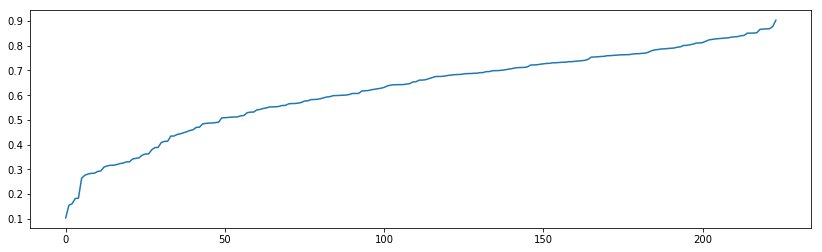

In [14]:
integs = [route['integ'] for route in routes]
plt.figure(figsize=(14, 4))
plt.plot(sorted(integs))
plt.show(); plt.close()

In [21]:
def trainable_inds(
        datamat,
        lag=6, # 5 timesteps (50 mins) of data availble
        minStops=10, # at least N stops back available
    ):
    # returns usable time-locale sections of the time-locale matrix
    tsize, ssize = datamat.shape
    inds = [] # ((at time, at stop, max poss. stops back))
    for ti in range(lag, tsize):
        for si in range(minStops, ssize):
            series = datamat[ti-lag:ti, si-minStops:si]
            if not np.count_nonzero(np.isnan(series)):
                inds.append((ti, si))
                
    return inds

data = history_byname('Q10_0')
segInds = trainable_inds(data)
print(len(segInds), len(segInds) / (data.shape[0] * data.shape[1]))

258684 0.48815670289855073


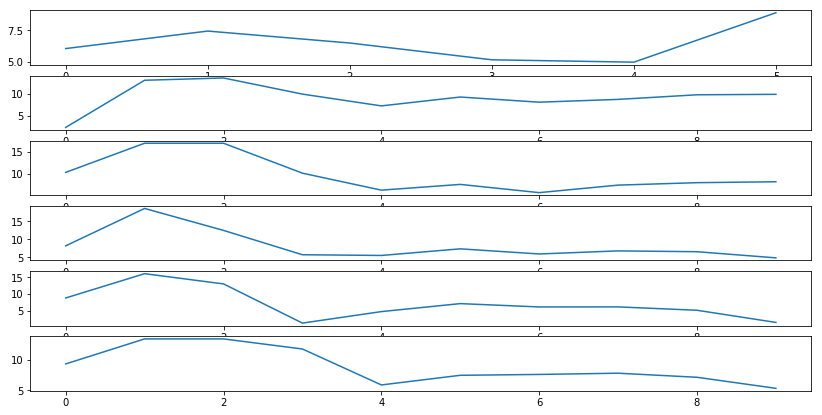

In [24]:
show_travels(data[:segInds[0][0], segInds[0][1]-10:segInds[0][1]], recent=6)

In [25]:
for route in tqdm(routes):
    data = history_byname(route['name'])
    inds = trainable_inds(data)
    route['trainable'] = inds

100%|██████████| 224/224 [09:34<00:00,  2.56s/it]


In [28]:
np.sum([len(rt['trainable']) for rt in routes]) / len(routes)

131699.3392857143

In [30]:
import json
with open('metadata.json', 'w') as fl:
    json.dump(routes, fl, indent=4)

In [32]:
minset = []
for route in tqdm(routes):
    subinds = []
    for ii, ref in enumerate(route['trainable']):
        if ii % 100 == 0:
            subinds.append(ref)
    obj = dict(
        name=route['name'],
        seglen=route['seglen'],
        integ=route['integ'],
        trainable=subinds)
    minset.append(obj)

100%|██████████| 224/224 [00:04<00:00, 45.27it/s]


In [33]:
with open('min-data.json', 'w') as fl:
    json.dump(minset, fl, indent=4)